## O datech

Data pocházejí z práce Davida Kubeši a Milana Straky ([DaMuEL: A Large Multilingual Dataset for Entity Linking](https://arxiv.org/abs/2306.09288)). Pro svoji práci jsem se rozhodl použít jen data z language agnostic části jejich datasetu a to pouze (Q)ID těchto entit. ID odpovídají existujícím entitám z wikipedie. K dispozici je 30 000 000 čísel z 4 bajtového rozsahu. Cílem tohoto notebooku je data prozkoumat a porovnat na nich dva algoritmy pro hledání v setřízené posloupnosti.

## Načítání dat

In [1]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import random
from random import choice

In [2]:
random.seed(1874)

In [3]:
def load_gzip_np(path):
    with gzip.open(path, 'r') as f:
        return np.load(file=f)

In [4]:
first = load_gzip_np("qids.txt.1.gz")
second = load_gzip_np("qids.txt.2.gz")
ids = np.concatenate((first, second))

In [5]:
ids = np.sort(ids)

## Statistiky

Přirozenou hypotézou by bylo předpokládat, že data jsou v celém úseku uniformě rozdělená. Jak se ale záhy ukáže, tato domněnka není správná.

### Základní zkoumání dat

In [6]:
ids_series = pd.Series(ids)

In [7]:
ids_series.describe()

count    3.279219e+07
mean     4.556283e+07
std      3.815394e+07
min      1.000000e+00
25%      1.305270e+07
50%      2.978788e+07
75%      7.892978e+07
max      1.151340e+08
dtype: float64

Z předchozí buňky můžeme odvodit několik závěrů:
- medián je nižší než průměr. Distribuce popisující data nejspíš nebude symetrická. Je možné, že v datech jsou outliers, kteří zvyšují průměr, který je vůči nim citlivější.
- Uvažujeme-li rozsah od min do max, tak více než 2/3 intervalu jsou nevyužity. Pokud bychom uvažovali celý 4B potenciální rozsah id, bude to samozřejmě více.

In [8]:
def make_histogram(bins):
    ids_series.plot(kind='hist', edgecolor='black', bins=bins)
    plt.title('Histogram of IDs')
    plt.xlabel('Value')
    plt.ylabel('Datapoints count')
    plt.show()

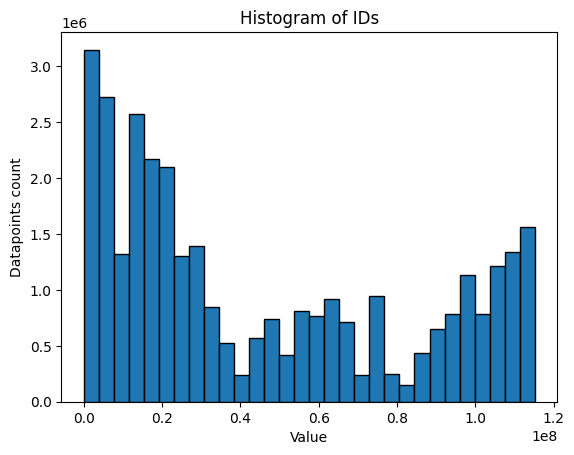

In [9]:
make_histogram(30)

Histogram prozrazuje, že hypotéza s asymetričností byla správná. Vzhledem ke zdroji dat není překvapující, že nejvíce hodnot má nižší id. Za povšimnutí stojí to, že v pravém okraji intervalu počty opět rostou.
Kvalitativně je vidět, že data nejsou z uniformního rozdělení. Histogram by spíše odpovídal bimodálnímu. Každopádně i tak nepředpokládám, že půjde nalézt distribuce, která by data dobře popisovalo a to kvůli původu dat. Předpokládám, že podobné entity budou mít ID blízko u sebe a mezi nimi budou mezery. Tak lze aspoň soudit z následujícího histogramu s vyšší granularitou.

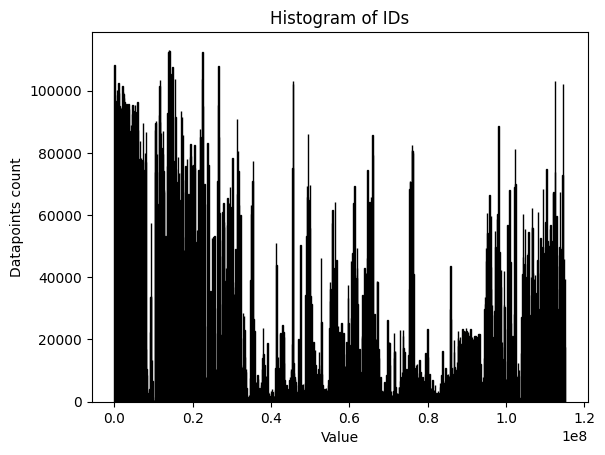

In [10]:
make_histogram(1000)

## Který algoritmus je nejlepší?

Na datech nyní zkusíme spustit dva algoritmy a vybrat ten, který bude v nějakém smyslu nejlepší. Každý algoritmus poběží vícekrát. Tím získáme náhodné výběry, z nich průměry a na závěr se pokusíme určit, jestli jsou průměry rozdílné, nebo v rámci statistické chyby.

První algoritmus bude klasické binární vyhledávání.

Druhý bude postupovat zleva a postupně rozšiřovat okénko. Až bude okénko dost velké, pustí na něj binární vyhledávání.

In [11]:
def binary(t, arr):
    cnt = 0
    l, r = 0, len(arr) - 1
    while l <= r:
        m = (l + r) // 2
        x = arr[m]
        cnt += 1
        if x < t:
            l = m + 1
        elif x > t:
            r = m - 1
        else:
            return cnt
    return cnt

def binary_left(t, arr, window_multiplier=2):
    cnt = 0
    right_end = 0
    while right_end < len(arr):
        x = arr[right_end]
        cnt += 1
        if x < t:
            if right_end == 0:
                right_end = 1
            else:
                right_end *=  window_multiplier
        elif x > t:
            #print(t, cnt,  binary(t, arr[right_end // window_multiplier:right_end]))
            return cnt + binary(t, arr[right_end // window_multiplier:right_end])
        else:
            print(t, cnt)
            return cnt
    return cnt

### t-test

In [12]:
population_size = 100
binary_p = [binary(choice(ids), ids) for i in range(population_size)]
binary_left_p = [binary_left(choice(ids), ids) for i in range(population_size)]

In [13]:
var_binary_p = np.std(binary_p) ** 2
var_left_binary_p = np.std(binary_left_p) ** 2
print("Rozptyl binarni:", var_binary_p)
print("Rozptyl binarni z leva:", var_left_binary_p)

Rozptyl binarni: 1.6199999999999999
Rozptyl binarni z leva: 101.19709999999999


Vidíme, že rozptyly jsou velmi rozdílné. Proto nemůžeme použít klasický Studentův t-test, ale poněkud sofistikovanější Welchův t-test, který již podmínky na stejné rozptyly neklade.

In [14]:
p = stats.ttest_ind(binary_p, binary_left_p, equal_var=False)
print(p)

TtestResult(statistic=-12.000832639025251, pvalue=3.148060885762885e-21, df=102.16884397505441)


p-value je blízké nule, tudíž nulová hypotéza (tedy to, že jsou průměry vzorků stejné) téměř jistě neplatí. Tento výsledek je očekávatelný vzhledem k tomu, že oba algoritmy jsou rozdílné. Jak navíc vidíme v následující buňce, rozdíl průměrů je viditelný na první pohled.

In [15]:
print("Průměr binární:", np.mean(binary_p))
print("Průměr binární zleva:",np.mean(binary_left_p))

Průměr binární: 24.0
Průměr binární zleva: 36.23


Dalo by se namítnout, proč se pak vůbec obtěžovat se statistickým testem. Jak je ale vidět v následujícím příkladě, vyvrátit nulovou hypotézu je těžší, když místo dvojnásobení budeme v *binárním vyhledávání zleva* násobit čtyřmi.

In [16]:
population_size = 100
binary_p = [binary(choice(ids), ids) for i in range(population_size)]
binary_left_p = [binary_left(choice(ids), ids, 4) for i in range(population_size)]
print("Průměr binární:", np.mean(binary_p))
print("Průměr binární zleva:",np.mean(binary_left_p))

Průměr binární: 24.15
Průměr binární zleva: 25.56


In [17]:
p = stats.ttest_ind(binary_p, binary_left_p, equal_var=False)
print(p)

TtestResult(statistic=-1.2439518435148147, pvalue=0.21637432941797685, df=101.78964808748776)


Vidíme, že zde už ani Welchův t-test nedává tak jasnou odpověď. Proto zkusíme zvýšit počet pozorování.

In [18]:
population_size = 1000
binary_p = [binary(choice(ids), ids) for i in range(population_size)]
binary_left_p = [binary_left(choice(ids), ids, 4) for i in range(population_size)]
print("Průměr binární:", np.mean(binary_p))
print("Průměr binární zleva:",np.mean(binary_left_p))

Průměr binární: 24.023
Průměr binární zleva: 25.072


In [19]:
p = stats.ttest_ind(binary_p, binary_left_p, equal_var=False)
print(p)

TtestResult(statistic=-3.002597312952272, pvalue=0.0027412893552797484, df=1032.8589065011063)


Opět můžeme tvrdit, že průměrný počet přístupů do pole se pro dva zmíněné algoritmy liší.

Jako třešničku na dortu, můžeme okénko rozšiřovat ještě rychleji.

In [20]:
population_size = 1000
binary_p = [binary(choice(ids), ids) for i in range(population_size)]
binary_left_p = [binary_left(choice(ids), ids, 32) for i in range(population_size)]
print("Průměr binární:", np.mean(binary_p))
print("Průměr binární zleva:",np.mean(binary_left_p))

Průměr binární: 23.971
Průměr binární zleva: 6.524


Vidíme, že vyhledávání zleva je výrazně rychlejší. To je nejspíše dáno rozložením dat, které jsme zkoumali na začátku. Mnohem víc dat se totiž nechází na nižších hodnotách rozsahu.